# --- Step 0: Import Libraries and Load Data ---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.ticker import FuncFormatter

In [2]:
# Load the datasets
audit_fees = pd.read_csv('audit_fees_from_wrds.csv', sep=',')
cams = pd.read_csv('cams_from_wrds.csv', sep=',')
audit_opinions = pd.read_csv('audit_opinions_wrds.csv', sep=',')
# Verify the data loaded by printing the first few rows
print("---Audit Fees Data---")
print(audit_fees.head())
print("---CAMs Data---")
print(cams.head())
print("---Audit Opinions Data---")
print(audit_opinions.head())

---Audit Fees Data---
   FISCAL_YEAR  AUDIT_FEES   FILE_DATE  COMPANY_FKEY  MATCHFY_BALSH_BOOK_VAL  \
0         2020     2007000  2020-08-28          1750             780900000.0   
1         2021     1930500  2021-08-18          1750             850600000.0   
2         2022     1998416  2022-08-09          1750             914800000.0   
3         2023     1998132  2023-08-08          1750             859600000.0   
4         2024     2952000  2024-08-06          1750             399600000.0   

   MATCHFY_BALSH_ASSETS  MATCHFY_INCMST_NETINC_TTM  SIC_CODE_FKEY  \
0          2.079000e+09                  4400000.0         3720.0   
1          1.539700e+09                 35800000.0         3720.0   
2          1.573900e+09                 78700000.0         3720.0   
3          1.833100e+09                 90200000.0         3720.0   
4          2.770000e+09                 46300000.0         3720.0   

   CURR_AUD_FKEY CURR_AUD_NAME  
0              4      KPMG LLP  
1              4

# --- Step 1: Filter Audit Fees for Fiscal Years 2020-2025 and Big 4 Firms ---

In [3]:
# Filter audit_fees for Fiscal Year 2020-2025

audit_fees_filtered = audit_fees[
    (audit_fees['FISCAL_YEAR'] >= 2020) & (audit_fees['FISCAL_YEAR'] <= 2025)
]

In [4]:
# Filter audit_fees_filtered for Big 4 Firms

# Define the keywords for the Big 4 firms
big4_keywords = ['PricewaterhouseCoopers', 'Ernst & Young', 'Deloitte', 'KPMG']

# Create a filter (mask) that checks if the auditor name contains any of these keywords
mask_big4 = audit_fees_filtered['CURR_AUD_NAME'].str.contains('|'.join(big4_keywords), na=False)

# Apply the filter to create a new dataframe
audit_fees_filtered_big_4 = audit_fees_filtered[mask_big4].copy()

# Check the results
print(f"Original Row Count: {len(audit_fees_filtered)}")
print(f"Big 4 Row Count: {len(audit_fees_filtered_big_4)}")
print("\n--- Auditor Counts ---")
print(audit_fees_filtered_big_4['CURR_AUD_NAME'].value_counts())

Original Row Count: 51703
Big 4 Row Count: 28673

--- Auditor Counts ---
CURR_AUD_NAME
PricewaterhouseCoopers LLP    8935
Deloitte & Touche LLP         7661
Ernst & Young LLP             7221
KPMG LLP                      4856
Name: count, dtype: int64


# --- Step 2: Merge Opinions into CAMs to get the Fiscal Year ---

In [5]:
# We only need the key and the year from the opinions file
# We create a subset so we don't duplicate columns we don't need
opinions_subset = audit_opinions[['AUDIT_OP_KEY', 'FISCAL_YEAR_OF_OP']]

# Merge them into the CAMs dataframe
# left_on points to the key in 'cams', right_on points to the key in 'opinions'
cams_with_year = pd.merge(
    cams,
    opinions_subset,
    left_on='AUDIT_OPINION_FKEY',
    right_on='AUDIT_OP_KEY',
    how='left'
)

# Verify the merge: Check if 'FISCAL_YEAR_OF_OP' now exists in the CAMs data
print("--- CAMs with Year Added ---")
print(cams_with_year[['CRITICAL_AUDIT_MATTER_KEY', 'FISCAL_YEAR_OF_OP']].head())

--- CAMs with Year Added ---
   CRITICAL_AUDIT_MATTER_KEY  FISCAL_YEAR_OF_OP
0                      12414             2021.0
1                      12415             2021.0
2                      21834             2022.0
3                      21835             2022.0
4                      30697             2023.0


In [6]:
# Check how many CAMs failed to find a year (Missing values)
missing_years = cams_with_year['FISCAL_YEAR_OF_OP'].isna().sum()
print(f"Rows with missing years: {missing_years}")

# Drop rows where the year is missing (we can't use them)
cams_with_year = cams_with_year.dropna(subset=['FISCAL_YEAR_OF_OP'])

# Convert the year column to Integer (removes the .0)
cams_with_year['FISCAL_YEAR_OF_OP'] = cams_with_year['FISCAL_YEAR_OF_OP'].astype(int)

# Check the result
print("--- Fixed Years ---")
print(cams_with_year[['CRITICAL_AUDIT_MATTER_KEY', 'FISCAL_YEAR_OF_OP']].head())

Rows with missing years: 443
--- Fixed Years ---
   CRITICAL_AUDIT_MATTER_KEY  FISCAL_YEAR_OF_OP
0                      12414               2021
1                      12415               2021
2                      21834               2022
3                      21835               2022
4                      30697               2023


In [7]:
# Pivot the CAMs Table

cam_types = pd.pivot_table(
    cams_with_year,
    index=['COMPANY_FKEY', 'FISCAL_YEAR_OF_OP'],
    columns='TOPIC_NAME',
    aggfunc='size',
    fill_value=0
).reset_index()

# Clean up column names
# We'll add a prefix "CAM_" to make them easy to identify later
cam_types.columns.name = None  # Remove the index name
new_columns = ['COMPANY_FKEY', 'FISCAL_YEAR_OF_OP'] + ['CAM_' + col.replace(' ', '_') for col in cam_types.columns[2:]]
cam_types.columns = new_columns


# We still want the TOTAL count (including the rare ones we filtered out)
# So let's merge this back with our original total count
total_counts = cams_with_year.groupby(['COMPANY_FKEY', 'FISCAL_YEAR_OF_OP']).size().reset_index(name='NUM_CAMS')

# Merge detailed types with total counts
final_cam_data = pd.merge(total_counts, cam_types, on=['COMPANY_FKEY', 'FISCAL_YEAR_OF_OP'], how='left')

print(final_cam_data.head())

   COMPANY_FKEY  FISCAL_YEAR_OF_OP  NUM_CAMS  CAM_Accounts/loans_receivable  \
0          1750               2020         2                              0   
1          1750               2021         2                              0   
2          1750               2022         2                              0   
3          1750               2023         2                              0   
4          1750               2024         2                              0   

   CAM_Allowance_for_credit_losses  \
0                                0   
1                                0   
2                                0   
3                                0   
4                                0   

   CAM_Asset_retirement_and_environmental_obligations  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4          

# --- Step 3: Merge Audit Fees with CAM Counts ---

In [8]:
# Merge audit_fees (left) with final_cam_data (right)
# Left Key: COMPANY_FKEY, FISCAL_YEAR
# Right Key: COMPANY_FKEY, FISCAL_YEAR_OF_OP
df_merged = pd.merge(
    audit_fees_filtered_big_4,
    final_cam_data,
    left_on=['COMPANY_FKEY', 'FISCAL_YEAR'],
    right_on=['COMPANY_FKEY', 'FISCAL_YEAR_OF_OP'],
    how='left'
)

# Check the result
print("--- Merged Data with CAM Types ---")
# Show specific columns to verify
cols_to_show = ['COMPANY_FKEY', 'FISCAL_YEAR', 'AUDIT_FEES', 'NUM_CAMS']
print(df_merged[cols_to_show].head())

--- Merged Data with CAM Types ---
   COMPANY_FKEY  FISCAL_YEAR  AUDIT_FEES  NUM_CAMS
0          1750         2020     2007000       2.0
1          1750         2021     1930500       2.0
2          1750         2022     1998416       2.0
3          1750         2023     1998132       2.0
4          1750         2024     2952000       2.0


# --- Step 4: Clean Merged Data ---

In [9]:
# Fill NaN values in NUM_CAMS with 0 (since they didn't match the CAM file)
df_merged['NUM_CAMS'] = df_merged['NUM_CAMS'].fillna(0)

# Fill NaN values in the specific CAM topic columns with 0 as well
# (We get the list of CAM columns from the merged dataframe)
cam_cols = [col for col in df_merged.columns if 'CAM_' in col]
df_merged[cam_cols] = df_merged[cam_cols].fillna(0)

In [10]:
# Rename Columns

df_merged_renamed = df_merged.rename(columns={
    'MATCHFY_BALSH_BOOK_VAL': 'BOOK_VAL',
    'MATCHFY_BALSH_ASSETS': 'TOTAL_ASSETS',
    'MATCHFY_INCMST_NETINC_TTM': 'NET_INCOME_TTM',
    'MATCHFY_INCOME_STMT_REVENUE': 'REVENUE',
    'SIC_CODE_FKEY': 'SIC_CODE'
})

In [11]:
# Handle Missing Data
# Rationale: We must drop any row that is missing a variable
# we intend to use in our model.
print(f"Original row count: {len(df_merged_renamed)}")

# We define our list of "must-have" columns for the regression
required_cols = ['AUDIT_FEES', 'TOTAL_ASSETS', 'BOOK_VAL',
                 'NET_INCOME_TTM', 'SIC_CODE', 'NUM_CAMS']


Original row count: 28673


In [12]:
# .dropna() removes any row with 'NaN' in this subset
df_clean = df_merged_renamed.dropna(subset=required_cols)

print(f"Row count after dropping NaNs: {len(df_clean)}")

Row count after dropping NaNs: 13986


In [13]:
# --- INVESTIGATION CODE ---

# 1. Check where the missing values are coming from
print("--- Missing Values by Column (Before Drop) ---")
missing_counts = df_merged_renamed[required_cols].isna().sum()
print(missing_counts)

# 2. Check specifically how many rows have missing CAM counts
missing_cams = df_merged_renamed['NUM_CAMS'].isna().sum()
print(f"\nRows with missing NUM_CAMS (likely 0 CAMs): {missing_cams}")

--- Missing Values by Column (Before Drop) ---
AUDIT_FEES            0
TOTAL_ASSETS       4847
BOOK_VAL          11339
NET_INCOME_TTM     5075
SIC_CODE           9358
NUM_CAMS              0
dtype: int64

Rows with missing NUM_CAMS (likely 0 CAMs): 0


In [14]:
# --- 4.2: Handle Non-Positive Values ---
# Rationale: We cannot take the log of zero or a negative number.
# Financial data (like 'AUDIT_FEES' and 'TOTAL_ASSETS') must be
# positive. We'll filter for this. 'book_value' can be negative,
# so we'll be careful.

df_clean = df_clean[df_clean['AUDIT_FEES'] > 0]
df_clean = df_clean[df_clean['TOTAL_ASSETS'] > 0]

# For book_value, we will only log it if it's positive.
# For net_income, we'll create a separate 'is_loss' flag.

print(f"Row count after ensuring 'fees' and 'assets' > 0: {len(df_clean)}")

Row count after ensuring 'fees' and 'assets' > 0: 13967


In [15]:
### Part 4.3: Feature Engineering (Log Transforms)
# Rationale: This is a key part of our proposal. We log these
# variables to reduce skewness and model the relationships
# in proportional terms (elasticity).

# Log transform fees and assets
df_clean['LOG_AUDIT_FEES'] = np.log(df_clean['AUDIT_FEES'])

# --- CORRECTED LINE BELOW ---
# My original code had a typo. This is the correct line.
df_clean['LOG_TOTAL_ASSETS'] = np.log(df_clean['TOTAL_ASSETS'])

# Log transform book_value only where it's positive
# We create 'LOG_BOOK_VAL' and fill negatives/zeros with NaN
# This line is *expected* to produce a RuntimeWarning, which is fine.
df_clean['LOG_BOOK_VAL'] = np.where(
    df_clean['BOOK_VAL'] > 0,
    np.log(df_clean['BOOK_VAL']),
    np.nan
)

# For cam_count, we use log(x + 1) to handle the '0' values.
# This is a standard transformation for count data.
df_clean['LOG_NUM_CAMS'] = np.log(df_clean['NUM_CAMS'] + 1)

C:\Users\campb\DataspellProjects\ac547-public\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
# --- 4.4: Feature Engineering (Other Variables) ---
# Rationale: We create a simple 'IS_LOSS' dummy variable for
# profitability and simplify 'SIC_CODE' to a 2-digit industry.

# Create a 1/0 dummy variable for 'is_loss'
df_clean['IS_LOSS'] = (df_clean['NET_INCOME_TTM'] < 0).astype(int)

# Convert SIC code to a 2-digit industry group
# .str.slice(0, 2) takes the first two characters
df_clean['SIC_CODE'] = df_clean['SIC_CODE'].astype(str).str.slice(0, 2)

print("Feature engineering complete.")

Feature engineering complete.


In [17]:
# --- 4.5: Final Inspection of Cleaned Data ---
print("\n--- Final Clean DataFrame Head ---")
print(df_clean.head())

print("\n--- Final Clean DataFrame Info ---")
df_clean.info()

print("\n--- Final Clean DataFrame Statistics (describe) ---")
# .describe() is a *mandatory* step. It shows us the
# mean, median, min, and max of our new variables.
print(df_clean.describe())


--- Final Clean DataFrame Head ---
   FISCAL_YEAR  AUDIT_FEES   FILE_DATE  COMPANY_FKEY     BOOK_VAL  \
0         2020     2007000  2020-08-28          1750  780900000.0   
1         2021     1930500  2021-08-18          1750  850600000.0   
2         2022     1998416  2022-08-09          1750  914800000.0   
3         2023     1998132  2023-08-08          1750  859600000.0   
4         2024     2952000  2024-08-06          1750  399600000.0   

   TOTAL_ASSETS  NET_INCOME_TTM SIC_CODE  CURR_AUD_FKEY CURR_AUD_NAME  ...  \
0  2.079000e+09       4400000.0       37              4      KPMG LLP  ...   
1  1.539700e+09      35800000.0       37              4      KPMG LLP  ...   
2  1.573900e+09      78700000.0       37              4      KPMG LLP  ...   
3  1.833100e+09      90200000.0       37              4      KPMG LLP  ...   
4  2.770000e+09      46300000.0       37              4      KPMG LLP  ...   

   CAM_Shareholder_valuation  CAM_Subsidiary/affiliate  \
0                     

# --- Step 5: Descriptive Statistics ---

In [18]:
# 1. Define the variables we want to summarize
# We include both the raw values (for interpretation) and logged values (for the model)
desc_vars = [
    'AUDIT_FEES', 'LOG_AUDIT_FEES',
    'TOTAL_ASSETS', 'LOG_TOTAL_ASSETS',
    'BOOK_VAL',     # We included this in our "High Quality" set
    'LOG_BOOK_VAL', 'NET_INCOME_TTM',
    'NUM_CAMS', 'LOG_NUM_CAMS',
    'IS_LOSS'
]

In [19]:
# 2. Generate the statistics
# We use .describe() and then select specific metrics
desc_stats = df_clean[desc_vars].describe().T[['count', 'mean', 'std', 'min', '50%', 'max']]

In [20]:
# 3. Rename '50%' to 'Median' for professional presentation
desc_stats = desc_stats.rename(columns={'50%': 'median'})

In [21]:
# 4. Format the output to make it readable (2 decimal places)
print("--- Descriptive Statistics (N = 13,986) ---")
print(desc_stats.apply(lambda x: x.map('{:,.2f}'.format)))

--- Descriptive Statistics (N = 13,986) ---
                      count               mean                 std  \
AUDIT_FEES        13,967.00       4,952,292.07        8,261,828.79   
LOG_AUDIT_FEES    13,967.00              14.76                1.13   
TOTAL_ASSETS      13,967.00  35,225,138,007.47  185,063,372,077.84   
LOG_TOTAL_ASSETS  13,967.00              21.96                2.07   
BOOK_VAL          13,967.00   2,701,725,261.05   20,459,880,630.10   
LOG_BOOK_VAL       9,835.00              20.38                2.03   
NET_INCOME_TTM    13,967.00     768,469,505.22    3,863,926,247.77   
NUM_CAMS          13,967.00               1.37                1.19   
LOG_NUM_CAMS      13,967.00               0.77                0.42   
IS_LOSS           13,967.00               0.35                0.48   

                                  min            median                   max  
AUDIT_FEES                   9,500.00      2,476,041.00        144,000,000.00  
LOG_AUDIT_FEES           

In [22]:
# Optional: Check the "frequency" of specific CAM topics if you are interested
print("\n--- Frequency of Top 5 CAM Topics ---")
cam_cols = [c for c in df_clean.columns if 'CAM_' in c]
print(df_clean[cam_cols].mean().sort_values(ascending=False).head(5))


--- Frequency of Top 5 CAM Topics ---
CAM_Revenue_from_customer_contracts    0.235627
CAM_Goodwill                           0.171332
CAM_Business_combinations              0.128374
CAM_Allowance_for_credit_losses        0.073888
CAM_Other_contingent_liabilities       0.071096
dtype: float64


# --- Step 7: OLS Regression Analysis ---

In [23]:
# Define the Regression Formula
# We predict Log Audit Fees using:
# - Size (LOG_TOTAL_ASSETS)
# - Complexity (LOG_NUM_CAMS)
# - Risk (IS_LOSS)
# - Valuation/Growth (LOG_BOOK_VAL)
# - Industry Fixed Effects (C(SIC_CODE))
formula = 'LOG_AUDIT_FEES ~ LOG_TOTAL_ASSETS + LOG_NUM_CAMS + IS_LOSS + LOG_BOOK_VAL + C(SIC_CODE)'

In [24]:
# Fit the Model
# statsmodels will automatically drop the few rows where LOG_BOOK_VAL is NaN (negative equity)
model = smf.ols(formula=formula, data=df_clean)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         LOG_AUDIT_FEES   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     317.5
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        19:43:47   Log-Likelihood:                -9462.8
No. Observations:                9835   AIC:                         1.906e+04
Df Residuals:                    9766   BIC:                         1.956e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.3015      0.63

# --- Step 8: Visualizations ---

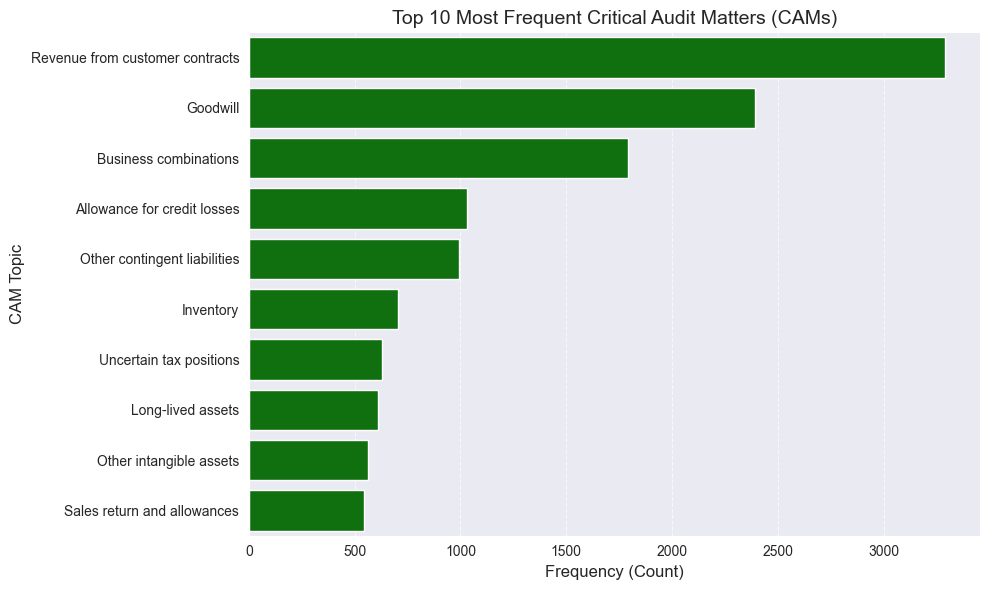

In [25]:
# 1. Identify CAM columns (they start with 'CAM_')
cam_cols = [col for col in df_clean.columns if 'CAM_' in col]

# 2. Sum the counts for each topic and sort descending
cam_frequencies = df_clean[cam_cols].sum().sort_values(ascending=False)

# 3. Clean up the names for the chart (remove 'CAM_' and underscores)
cam_frequencies.index = [idx.replace('CAM_', '').replace('_', ' ') for idx in cam_frequencies.index]

# 4. Plot the Top 10
plt.figure(figsize=(10, 6))
sns.barplot(x=cam_frequencies.head(10).values, y=cam_frequencies.head(10).index, color='green')

plt.title('Top 10 Most Frequent Critical Audit Matters (CAMs)', fontsize=14)
plt.xlabel('Frequency (Count)', fontsize=12)
plt.ylabel('CAM Topic', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

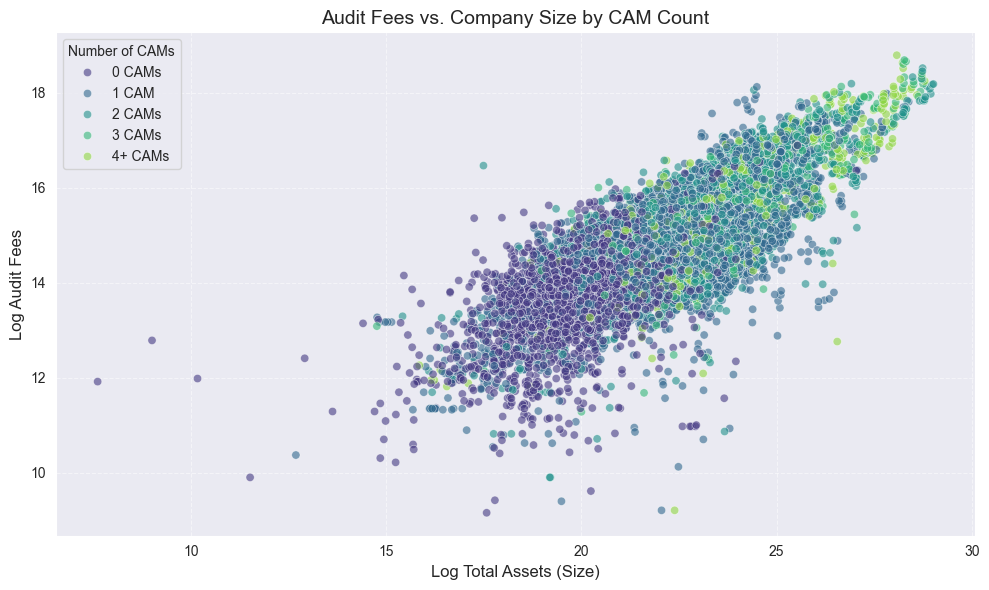

In [26]:
# 1. Create a "CAM Group" column to make the legend cleaner
# We group 4 or more CAMs together since they are rare
def bin_cams(x):
    if x == 0: return '0 CAMs'
    elif x == 1: return '1 CAM'
    elif x == 2: return '2 CAMs'
    elif x == 3: return '3 CAMs'
    else: return '4+ CAMs'

df_clean['CAM_Group'] = df_clean['NUM_CAMS'].apply(bin_cams)

# 2. Define the order for the legend so it makes sense (0 -> 4+)
hue_order = ['0 CAMs', '1 CAM', '2 CAMs', '3 CAMs', '4+ CAMs']

# 3. Create the Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x='LOG_TOTAL_ASSETS',
    y='LOG_AUDIT_FEES',
    hue='CAM_Group',       # Color points by group
    hue_order=hue_order,   # Use our custom order
    alpha=0.6,             # Make points slightly transparent
    palette='viridis'      # Use a colorblind-friendly palette
)

# 4. Add Labels and Title
plt.title('Audit Fees vs. Company Size by CAM Count', fontsize=14)
plt.xlabel('Log Total Assets (Size)', fontsize=12)
plt.ylabel('Log Audit Fees', fontsize=12)
plt.legend(title='Number of CAMs')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

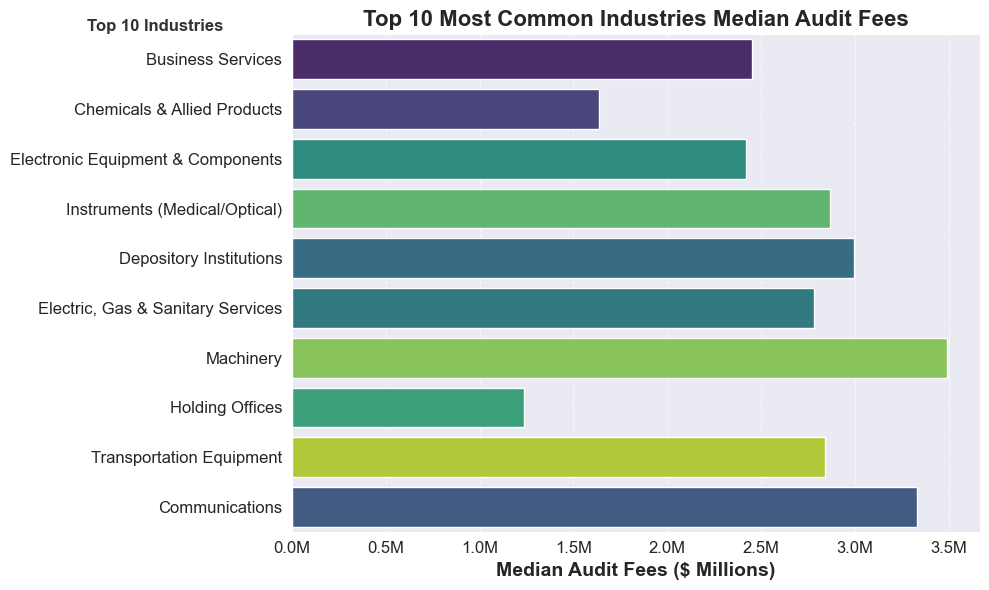

In [27]:
# --- Bar Chart of Median Audit Fees with Names ---

# 1. Filter for the Top 10 most common industries
top_10_sic = df_clean['SIC_CODE'].value_counts().head(10).index
df_top_sic = df_clean[df_clean['SIC_CODE'].isin(top_10_sic)].copy()

# 2. Create the "Name Mapper"
# This dictionary matches the 2-digit code to the Industry Name
sic_names = {
    '73': 'Business Services',
    '28': 'Chemicals & Allied Products',
    '36': 'Electronic Equipment & Components',
    '35': 'Machinery',
    '38': 'Instruments (Medical/Optical)',
    '62': 'Security & Commodity Brokers',
    '67': 'Holding Offices',
    '63': 'Insurance Carriers',
    '48': 'Communications',
    '13': 'Oil & Gas Extraction',
    '50': 'Wholesale Trade - Durable Goods',
    '87': 'Engineering/Accounting Services',
    '60': 'Depository Institutions',
    '49': 'Electric, Gas & Sanitary Services',
    '37': 'Transportation Equipment'

}

# 3. Apply the Names
# If a code isn't in our list (rare), it falls back to "SIC XX"
df_top_sic['Industry_Name'] = df_top_sic['SIC_CODE'].map(sic_names).fillna('SIC ' + df_top_sic['SIC_CODE'])

# 4. Define the Sort Order (Most Common -> Least Common)
# value_counts() automatically sorts by count descending
frequency_order = df_top_sic['Industry_Name'].value_counts().index

# Calculate the medians (we don't need to sort this dataframe anymore)
industry_medians = df_top_sic.groupby('Industry_Name')['AUDIT_FEES'].median().reset_index()

# 5. Create the Plot
plt.figure(figsize=(10, 6))

# Save the plot object to a variable 'ax' so we can manipulate the text
ax = sns.barplot(
    data=industry_medians,
    x='AUDIT_FEES',
    y='Industry_Name',
    hue='Industry_Name',
    palette='viridis',
    legend=False,
    order=frequency_order # Ensures 'Most Common' is at the top (index 0)
)

# --- FONT & FORMATTING CUSTOMIZATION ---
plt.title('Top 10 Most Common Industries Median Audit Fees', fontsize=16, fontweight='bold')
plt.xlabel('Median Audit Fees ($ Millions)', fontsize=14, fontweight='bold')

# Remove the default vertical Y-label
ax.set_ylabel('')

# --- ADDING THE SPLIT LABELS ---
# transform=ax.transAxes allows us to use relative coordinates (0 to 1)
# rather than data coordinates.
# (0, 1) is Top-Left. (0, 0) is Bottom-Left.

# 1. "Top 10 Industries" at the Top Left
ax.text(x=-0.1, y=1, s="Top 10 Industries",
        transform=ax.transAxes,
        ha='right', va='bottom', fontsize=12, fontweight='bold', color='#333333')


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# --- THE MAGIC FORMATTER ---
# Ensure you have: from matplotlib.ticker import FuncFormatter
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

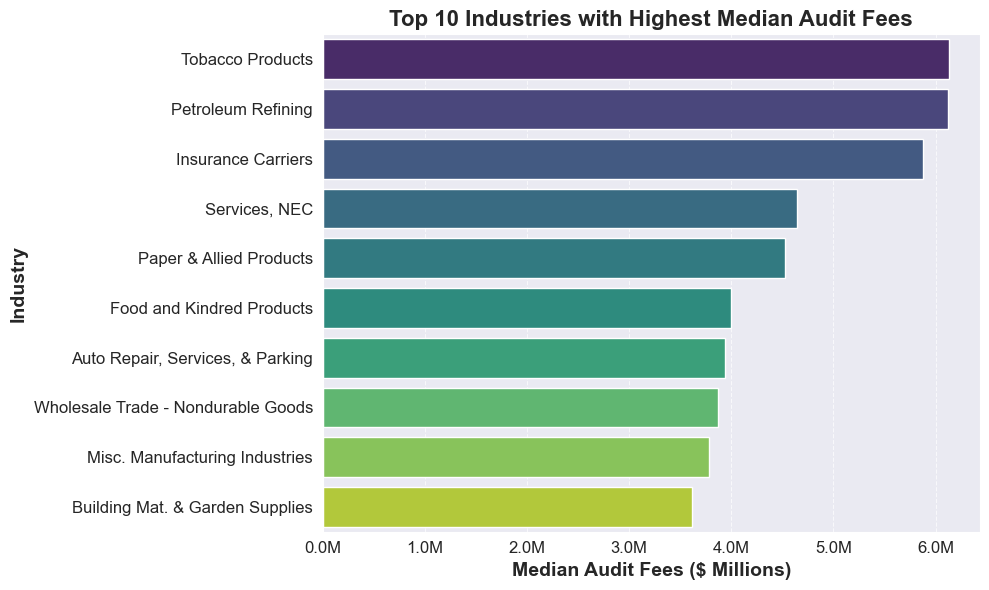

In [28]:
# 1. Prepare Data: Calculate Median Fees for ALL industries first
median_fees = df_clean.groupby('SIC_CODE')['AUDIT_FEES'].median()

# 2. Sort Descending and Take Top 10
top_10_highest = median_fees.sort_values(ascending=False).head(10).reset_index()
top_10_highest.columns = ['SIC_CODE', 'Median_Fee']

# 3. Updated Dictionary for High-Fee Industries
sic_names_high = {
    '21': 'Tobacco Products',
    '29': 'Petroleum Refining',
    '63': 'Insurance Carriers',
    '89': 'Services, NEC',
    '26': 'Paper & Allied Products',
    '20': 'Food and Kindred Products',
    '75': 'Auto Repair, Services, & Parking',
    '51': 'Wholesale Trade - Nondurable Goods',
    '39': 'Misc. Manufacturing Industries',
    '52': 'Building Mat. & Garden Supplies'
}

# 4. Apply Names
top_10_highest['Industry_Name'] = top_10_highest['SIC_CODE'].map(sic_names_high).fillna('SIC ' + top_10_highest['SIC_CODE'])

# 5. Create the Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_highest,
    x='Median_Fee',
    y='Industry_Name',
    hue='Industry_Name',
    palette='viridis',
    legend=False,  # Using 'magma' to signify "hot/expensive"
)

# --- FONT & FORMATTING ---
plt.title('Top 10 Industries with Highest Median Audit Fees', fontsize=16, fontweight='bold')
plt.xlabel('Median Audit Fees ($ Millions)', fontsize=14, fontweight='bold')
plt.ylabel('Industry', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Format X-axis to "6.0M"
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()